In [4]:
import pickle
import shutil
import sys
import os
import copy
from datetime import datetime
import time
from glob import glob
from sklearn.metrics import accuracy_score


import ipdb
import numpy as np
import cv2
import random
from pprint import pprint
import argparse
from shutil import copyfile
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os.path as osp

import networkx as nx
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import dgl
from dgl.data.utils import load_graphs
import json


sys.path.append(os.path.abspath("."))
sys.path.append(os.path.abspath(".."))

from data.coco_loader import coco_fake2names
from trainer import Trainer
from torch.utils.data import DataLoader
from data.data_loader import *
from models.registry import GCN_4_layer_fc
%matplotlib inline 
from IPython.display import clear_output

In [5]:
def drawBoundingBoxes(imagePath, inferenceResults):
    """Draw bounding boxes on an image.
    imageData: image data in numpy array format
    imageOutputPath: output image file path
    inferenceResults: inference results array off object (l,t,w,h)
    colorMap: Bounding box color candidates, list of RGB tuples.
    """
    imageData = cv2.imread(imagePath)
    for res in inferenceResults:
        left = int(res['left'])
        top = int(res['top'])
        right = int(res['right'])
        bottom = int(res['bottom'])
        label = res['label']
        color = res['color']
        imgHeight, imgWidth, _ = imageData.shape
        thick = int((imgHeight + imgWidth) // 500)
        cv2.rectangle(imageData,(left, top), (right, bottom), color, thick)
        cv2.putText(imageData, label, (left, top - 12), 0, 1e-3 * imgHeight, color, thick//2)
        
    return imageData
    

def quick_batch(batch_paths):
    batch, path_list = [], []
    for G_path in batch_paths:
        G, _ = load_graphs(G_path)
        G = G[0]
        batch.append(G)
        path_list.append(G_path)
    batch = dgl.batch(batch)
    return path_list, batch


def update_p_data(inputs_q, target_p):
    preds = trainer_q.predict(inputs_q, opt['tau'])
    target_p_orig = target_p.clone()
    if opt['draw'] == 'exp':
        target_p = preds.clone()
    # TODO: lets say we randomize here by 50% or 75%
    # or just take target_p and randomize gold by 50% and see
    elif opt['draw'] == 'max':
        idx_lb = torch.max(preds, dim=-1)[1]
        target_p.zero_().scatter_(1, torch.unsqueeze(idx_lb, 1), 1.0)
    elif opt['draw'] == 'smp':
        # TODO: make sure the multinomail gets only positve values
        positive_matrix = (preds - preds.min()) / (preds.max() - preds.min())
        # idx_lb = torch.multinomial(preds, 1).squeeze(1)
        idx_lb = torch.multinomial(positive_matrix, 1).squeeze(1)
        target_p.zero_().scatter_(1, torch.unsqueeze(idx_lb, 1), 1.0)
    if opt['use_gold'] == 1:
        # TODO: return true label here
        target_p = target_p_orig
    inputs_p = target_p.clone()
    return inputs_p, target_p


def update_q_data(inputs_p, target_q):
    preds = trainer_p.predict(inputs_p)
    if opt['use_gold'] == 1:
        # TODO: return true label here
        return target_q
    else:
        return preds.clone()


def validate(dataloader):
    all_graph_predictions = []
    all_graph_test_labels = []

    for step, G_batch in tqdm(enumerate(dataloader), desc="Validating", total=len(dataloader)):
        G_path_list, batch = quick_batch(G_batch)
        # TODO: fix this: label is subtracted -1 since 1 to 80
        per_graph_labels = batch.ndata['label'].to(device) - 1
        target_onehot = torch.zeros(len(per_graph_labels), opt['num_class']).to(device)
        target_onehot.scatter_(1, per_graph_labels.unsqueeze(1), 1.0)
        _, pred_labels, accuracy_dev = trainer_q.evaluate(batch, target_onehot, None)
        all_graph_predictions.append(pred_labels.cpu())
        all_graph_test_labels.append(per_graph_labels.to('cpu'))

    all_node_predictions = np.array(
        [node_pred.item() for graph_pred in all_graph_predictions for node_pred in graph_pred])
    all_node_test_labels = np.array(
        [node_labels.item() for graph_labels in all_graph_test_labels for node_labels in graph_labels])
    accuracy = (all_node_predictions == all_node_test_labels).sum() / len(all_node_test_labels)
    return accuracy


def pred_labelsfrom_q():
    # predict labels with the q network
    g_path_to_label = {}
    # all files
    files = os.listdir(osp.join(ROOT, "val"))
    for idx, gfile in tqdm(enumerate(files), total=len(files), desc="Predicting labels with Q"):
        g_path = os.path.join(ROOT, "val", gfile)
        parts = g_path.split("/")
        split = parts[-2]
        G, _ = load_graphs(g_path)
        G = G[0]
        # print(gfile)
        batch = G.to(device)
        # print("------------------------")
        # print("for q")
        # for q network
        logits = trainer_q.predict(batch)
        preds = torch.max(logits, dim=1)[1]
        # G.ndata['label'] = preds # get labels from q
        g_path_to_label[gfile] = preds
    return g_path_to_label


In [6]:
# PATHS
OOC_img_dirpath    = '/workspace/aroy/datasets/coco_ooc/OOC_images'
data_root = "/workspace/aroy/datasets/coco_ooc/graphs_normalized_part/"
model_dir = "/workspace/aroy/datasets/coco_ooc/models/extra_gmm_save/"
OOC_img_select_dirpath = '/workspace/aroy/datasets/coco_ooc/OOC_images_selected/'
OOC_img_op_dirpath = '/workspace/aroy/datasets/coco_ooc/OOC_images_outputs_selected/'

press any key to continue or q to exit  


 Out of context instance: Ground truth label: zebra | predicted label: laptop


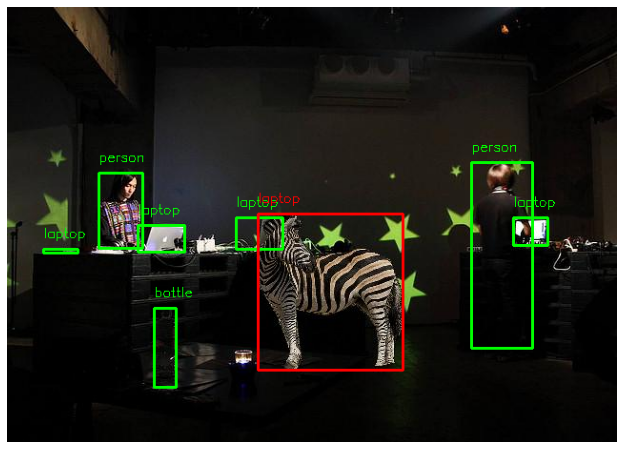

press any key to continue or q to exit  


 Out of context instance: Ground truth label: banana | predicted label: person


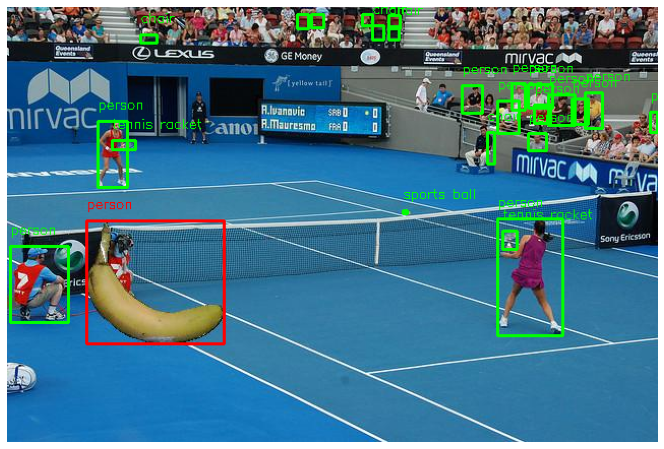

press any key to continue or q to exit  


 Out of context instance: Ground truth label: giraffe | predicted label: book


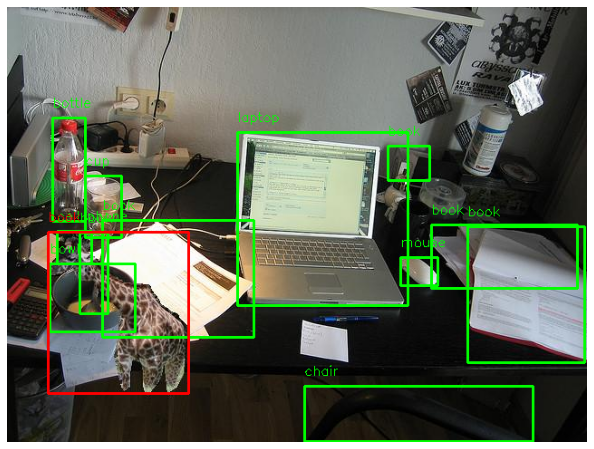

press any key to continue or q to exit  


 Out of context instance: Ground truth label: suitcase | predicted label: person


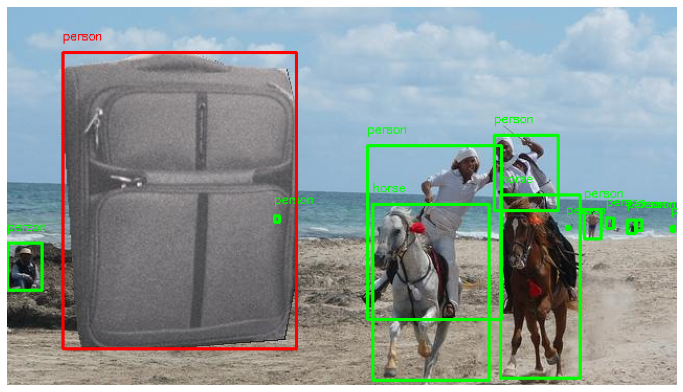

press any key to continue or q to exit  


 Out of context instance: Ground truth label: sheep | predicted label: chair


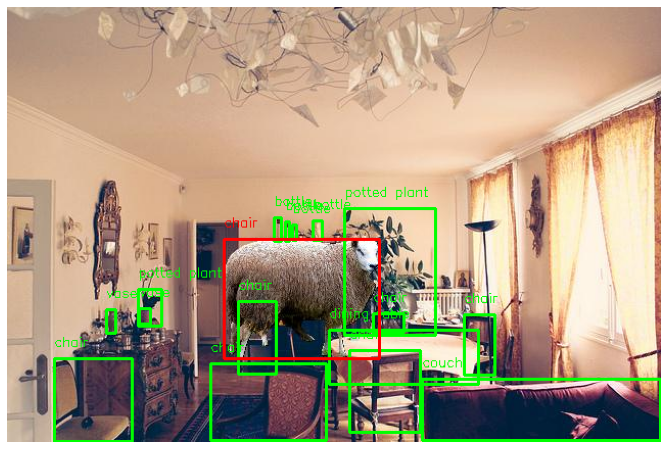

press any key to continue or q to exit  q


In [7]:

parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='data')
parser.add_argument('--save', type=str, default='gmnn_models')
parser.add_argument('--hidden_dim', type=int, default=16, help='Hidden dimension.')
parser.add_argument('--input_dropout', type=float, default=0.5, help='Input dropout rate.')
parser.add_argument('--dropout', type=float, default=0.5, help='Dropout rate.')
parser.add_argument('--optimizer', type=str, default='adam', help='Optimizer.')
parser.add_argument('--lr', type=float, default=0.01, help='Learning rate.')
parser.add_argument('--decay', type=float, default=5e-4, help='Weight decay for optimization')
parser.add_argument('--self_link_weight', type=float, default=1.0, help='Weight of self-links.')
parser.add_argument('--pre_epoch', type=int, default=200, help='Number of pre-training epochs.')
parser.add_argument('--epoch', type=int, default=200, help='Number of training epochs per iteration.')
parser.add_argument('--iter', type=int, default=10, help='Number of training iterations.')
parser.add_argument('--use_gold', type=int, default=1,
                    help='Whether using the ground-truth label of labeled objects, 1 for using, 0 for not using.')
parser.add_argument('--pred_label', action='store_true')
parser.add_argument('--tau', type=float, default=1.0, help='Annealing temperature in sampling.')
parser.add_argument('--draw', type=str, default='max',
                    help='Method for drawing object labels, max for max-pooling, smp for sampling.')
parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--cuda', type=bool, default=torch.cuda.is_available())
parser.add_argument('--cpu', action='store_true', help='Ignore CUDA.')
parser.add_argument('--testrun', action='store_true')
args = parser.parse_args("")


opt = vars(args)
##
opt['hidden_dim'] = 16
opt['input_dropout'] = 0.5
opt['dropout'] = 0
# opt['optimizer'] = 'adam'
# opt['lr'] = 0.01
# opt['decay'] = 5e-4
opt['optimizer'] = 'adamw'
opt['lr'] = 0.001
opt['decay'] = 0
opt['self_link_weight'] = 1.0
opt['pre_epoch'] = 5  # pre-training
opt['epoch'] = 10  # each epoch
opt['iter'] = 1
opt['use_gold'] = 1
# opt['draw'] = args.draw
opt['tau'] = 0.1
opt['num_class'] = 80
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 80
h1_dim = 256
h2_dim = 128
h3_dim = 64
h4_dim = 64
in_feats = 2048
geo_feat_len = 7
train_batch_size = 1024
val_batch_size = 1024

##add geo_feat_len i.e geo_feats here
p_in_feats = num_classes + geo_feat_len
gnnp = GCN_4_layer_fc(p_in_feats, h1_dim, h2_dim, h3_dim, h4_dim, num_classes).to(device)
#print(gnnp)
gnnq = GCN_4_layer_fc(in_feats, h1_dim, h2_dim, h3_dim, h4_dim, num_classes).to(device)
#print(gnnq)

opt['geo_feat_len'] = geo_feat_len  # only vis feat is used
opt['name'] = 'trainer_q'
trainer_q = Trainer(opt, gnnq)
# copy opt
opt_p = copy.deepcopy(opt)
opt_p['name'] = 'trainer_p'
opt_p['geo_feat_len'] = 0  # so that all features is used
trainer_p = Trainer(opt_p, gnnp)

#  ------- Main -----------------

os.makedirs(OOC_img_op_dirpath, exist_ok = True)

#---------- Models ----------
trainer_q.load(osp.join(model_dir, "gnnq.pt"))
trainer_p.load(osp.join(model_dir, "gnnp.pt"))

# ---------- Data ---------------
graph_dir_test = os.path.join(data_root, "val")
# print(f"testing {graph_dir_test}....")

# ----------- data loaders ------------
node_num_thresh = 0

if args.testrun:  # run test on few files
    graph_path_list_test_sel = sorted(glob(graph_dir_test + '/*.bin'))[:100]
else:
    graph_path_list_test_sel = glob(graph_dir_test + '/*.bin')
    # graph_path_list_test_sel = filter_graphs(graph_dir_test, node_num_thresh=node_num_thresh)

test_dataset = get_dataset(path_list=graph_path_list_test_sel)
test_dataloader = DataLoader(test_dataset, batch_size=val_batch_size)
print("dataloaders prepared .....")


coco_classes = set(coco_fake2names.values())
coco_names2fakeid = {v: k for k, v in coco_fake2names.items()}

# all files
files = os.listdir(osp.join(data_root, "val"))

img_files = os.listdir(OOC_img_select_dirpath)
select_bin_files = [file.replace(".jpg", ".bin") for file in img_files]


clear_output()
file_indx = 0
while input("press any key to continue or q to exit ") != "q":
    #clear_output()
    
    if file_indx == len(select_bin_files) - 1:
        break
        
    gfile = select_bin_files[file_indx]
    g_file_name = os.path.splitext(gfile)[0]
    annot_filepath = glob(os.path.join(OOC_img_dirpath, '**/' +  g_file_name + '.npy'), recursive=True)
    annot_data = np.load(annot_filepath[0], allow_pickle=True)

    file_indx = file_indx+1
    
    g_path = os.path.join(data_root, "val", gfile)
    parts = g_path.split("/")
    split = parts[-2]
    G, _ = load_graphs(g_path)
    G = G[0]
   
    #print(gfile)

    # for classificiaotn subtract -1
    per_graph_labels = G.ndata['label'].to(device) - 1
    target_onehot = torch.zeros(len(per_graph_labels), opt['num_class']).to(device)
    target_onehot.scatter_(1, per_graph_labels.unsqueeze(1), 1.0)

    # print("for p")
    # for p network
    batch = G.to(device)
    feats_old = batch.ndata['feature'].clone().detach()
    # batch.ndata['feature'] = target_onehot  # num_nodes x num_class
    # ----------------
    inputs_p_new = torch.cat((target_onehot, batch.ndata['geo_feature']), axis=1)
    batch.ndata['feature'] = inputs_p_new  # num_nodes x num_class
    # ----------------
    logits = trainer_p.predict(batch)
    target_idx = per_graph_labels + 1
    preds = torch.max(logits, dim=1)[1] + 1
    p_preds = preds
    softmaxes = torch.softmax(logits, dim=-1)
    correct = preds.eq(target_idx).double()
    accuracy = correct.sum() / len(preds)
    #print("accuracy {} ", 100 * accuracy.item())
    
    
    bbox_annotations = []
    bboxes = G.ndata['bbox']
    for i in range(len(preds)):
        t = target_idx[i].item()
        p = preds[i].item()
        conf = torch.max(softmaxes[i]).item()
        target_name = coco_fake2names.get(t)
        pred_name = coco_fake2names.get(p)
        
        
        if i < len(preds) - 1: # non-ooc
            # print(f"In context : ground_truth: {target_name}, prediction: {pred_name}")
            bbox_label = {"left": bboxes[i][0], "top": bboxes[i][1], "right": bboxes[i][2], "bottom": bboxes[i][3], "label": pred_name, "color": (0, 255, 0)}
            bbox_annotations.append(bbox_label)
        else: # last one is the ooc
            # print("-"*40)
            print(f" Out of context instance: Ground truth label: {target_name} | predicted label: {pred_name}")
            ooc_bbox = annot_data.item()['ooc_annotation']['bbox']
            #bbox_label = {"left": ooc_bbox[i][0], "top": bboxes[i][1], "right": bboxes[i][2], "bottom": bboxes[i][3], "label": pred_name, "color": (0, 0, 255)}
            bbox_label = {"left": ooc_bbox[1], "top": ooc_bbox[0], "right": ooc_bbox[1] + ooc_bbox[2], "bottom": ooc_bbox[0]+ooc_bbox[3], "label": pred_name, "color": (0, 0, 255)}
            bbox_annotations.append(bbox_label)
            
    
    # visualize and save
    # copy images to see
    imgfile = gfile.replace(".bin", ".jpg")
    src_img_path = glob(os.path.join(OOC_img_dirpath, '**', imgfile), recursive=True)
    dst_img_path = os.path.join(OOC_img_op_dirpath, imgfile)
    if len(src_img_path) > 0:
        imageData = drawBoundingBoxes(src_img_path[0], bbox_annotations)
        cv2.imwrite(dst_img_path, imageData)
        plt.figure(figsize = (12,8))
        plt.imshow(cv2.cvtColor(imageData, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        plt.close()
    else:
        print ("file is not present")

    